In [57]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import load_df, get_splits
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.linear_model import *


df = load_df()

print(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
                        datetime  import_capacity  upward_dispatch_published  \
0      2023-12-29 00:00:00+00:00             65.4                        0.0   
1      2023-12-29 00:01:00+00:00             65.4                        0.0   
2      2023-12-29 00:02:00+00:00             65.4                        0.0   
3      2023-12-29 00:03:00+00:00             65.4                        0.0   
4      2023-12-29 00:04:00+00:00             65.4                        0.0   
...                          ...              ...                        ...   
220241 2024-05-29 22:41:00+00:00           1982.6                      167.0   
220242 2024-05-29 22:42:00+00:00           1982.6                      165.0   
220243 2024-05-29 22:43:00+00:00           1982.6                      162.0   
220244 2024-05-29 22:44:00+00:00           1982.6                      158.0   
220245 2024-05-29 22:45:00+00:00

0.974417157705962
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     53623
        True       0.00      0.00      0.00      1023

    accuracy                           0.97     54646
   macro avg       0.49      0.50      0.49     54646
weighted avg       0.96      0.97      0.97     54646

Confusion Matrix:


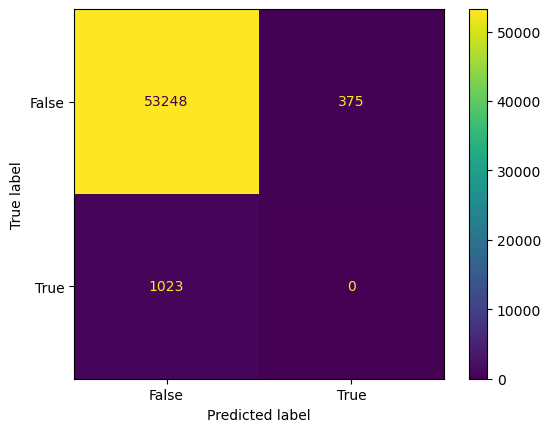

In [58]:
features = [
    "import_capacity",
    "settlement_price_bestguess",
]

splits = get_splits(df, ['PTU', 'import_capacity'], return_dict_pair=False)

train_x = splits['train'][0]
train_y = splits['train'][1]

test_x = splits['test'][0]
test_y = splits['test'][1]
ids = splits['test'][2]

# Initialize the Decision Tree Classifier
clf = HistGradientBoostingClassifier()

# Train the classifier
clf.fit(train_x, train_y)

y_pred = clf.predict(test_x)

# Evaluate the model
accuracy = accuracy_score(test_y, y_pred)
print(accuracy)

print("Classification Report:")
print(classification_report(test_y, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(test_y, y_pred)
plt.show()

In [59]:
def compute_penalty(df, pred, ids):
    total_penalty = 0

    pred_df = pd.DataFrame({
        "ptu_id": ids,
        "target_two_sided_ptu_pred": pred
    })
    
    df = df.set_index("ptu_id")
    pred_df = pred_df.set_index("ptu_id")
    
    df["target_two_sided_ptu_pred"] = pred_df["target_two_sided_ptu_pred"]

    df = df.reset_index()

    grouped = df.groupby("ptu_id")

    for _, job_df in grouped:
        if job_df['target_two_sided_ptu'].any():
            count = 0
            positive_found = False

            job_df = job_df.reset_index(drop=True)

            for _, row in job_df.iloc[2:].iterrows():
                min_price = row["min_price_published"]
                max_price = row["max_price_published"]

                if min_price < 0 and not positive_found:
                    count += 1

                if row['target_two_sided_ptu']:
                    if min_price < 0 and not positive_found:
                        count -= 1

                if pd.notna(max_price) and max_price > 0:
                    positive_found = True

            max_price = job_df["max_price_published"].max()
            if pd.notna(max_price):
                penalty = ((100 / 60) * max_price).round(-1) * count
                total_penalty += penalty

    return total_penalty

# def compute_reward(df, pred, ids):
#     total_reward = 0

#     pred_df = pd.DataFrame({
#         "ptu_id": ids,
#         "target_two_sided_ptu_pred": pred
#     })
    
#     df = df.set_index("ptu_id")
#     pred_df = pred_df.set_index("ptu_id")
    
#     df["target_two_sided_ptu_pred"] = pred_df["target_two_sided_ptu_pred"]

#     df = df.reset_index()

#     grouped = df.groupby("ptu_id")

#     for _, job_df in grouped:
#         if not job_df['target_two_sided_ptu'].any():

#             job_df = job_df.reset_index(drop=True)

#             if pd.notna(max_price):
#                 reward = ((100 / 60) * min_price).round(-1) * count
#                 total_reward += reward

#     return total_reward

compute_penalty(df, df['target_two_sided_ptu'], df['ptu_id'])

0.0

0.974417157705962
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     53623
        True       0.00      0.00      0.00      1023

    accuracy                           0.97     54646
   macro avg       0.49      0.50      0.49     54646
weighted avg       0.96      0.97      0.97     54646

Confusion Matrix:


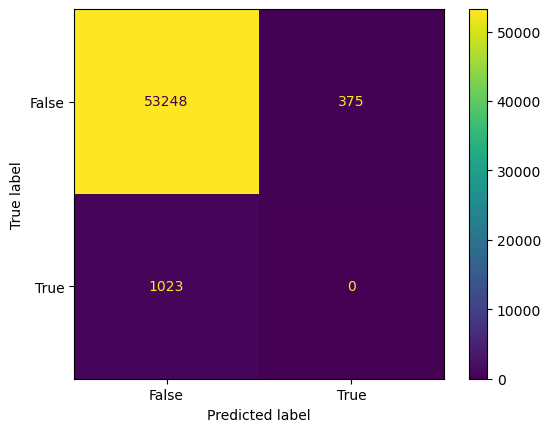

In [60]:
def flatten_ptu(true, pred, ids):
    # Concatenate the true, pred, and ids into a single DataFrame
    base = pd.concat([pd.Series(true), pd.Series(pred), pd.Series(ids)], axis=1, ignore_index=True)
    base.columns = ["target_two_sided_ptu", "target_two_sided_ptu_pred", "ptu_id"]

    # Group by the ptu_id and aggregate the true and pred values
    # Here we assume you want to flatten using some kind of aggregation, like mean
    df = base.groupby("ptu_id").agg({
        "target_two_sided_ptu": "any",
        "target_two_sided_ptu_pred": "any"
    }).reset_index()

    return df

def basic_metrics(true, pred, ids, flatten=True):
    if flatten:
        flattened = flatten_ptu(true, pred, ids)
        test_y = flattened['target_two_sided_ptu']
        y_pred = flattened['target_two_sided_ptu_pred']
    
    accuracy = accuracy_score(true, pred)
    print(accuracy)
    
    print("Classification Report:")
    print(classification_report(true, pred))
    
    # Print the confusion matrix
    print("Confusion Matrix:")
    ConfusionMatrixDisplay.from_predictions(true, pred)
    plt.show()
        


basic_metrics(test_y, y_pred, ids, flatten=False)


In [61]:
data = {
    'Time': [
        '11:30', '11:31', '11:32', '11:33', '11:34', '11:35', '11:36', 
        '11:37', '11:38', '11:39', '11:40', '11:41', '11:42', '11:43', 
        '11:44', '11:45'
    ],
    'min_price_published': [
        -100, np.NaN, 0, -100, -150, 
        -200, -300, -100, np.NaN, np.NaN, 
        np.NaN, np.NaN, np.NaN, -30, -100, 0
    ],
    'max_price_published': [
        np.NaN, 20, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, 
        40, 50, 90, 200, 80, 
        np.NaN, np.NaN, np.NaN
    ],
    'target_two_sided_ptu': [
        True, False, False, True, True, False, False, True, False, False,
         False, False, False, False, False, False
    ],
    'ptu_id':
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
}

df = pd.DataFrame(data)


compute_penalty(df, df['target_two_sided_ptu'], df['ptu_id'])

660.0